In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


In [3]:
def f(x):
    return 1 / (1 + np.exp(-x))

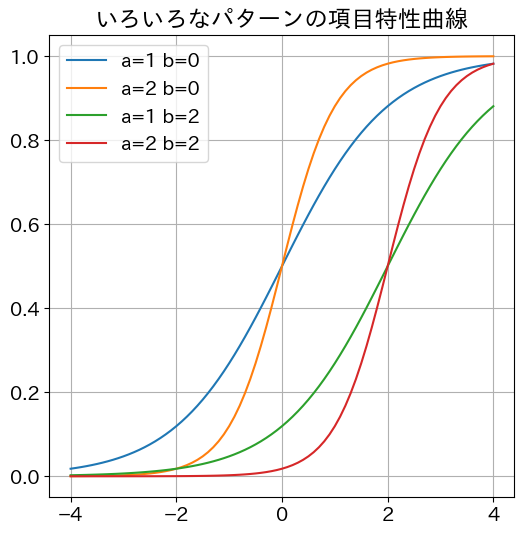

,a(識別力),b(困難度),f(1),f(2)
問題1,1.000,0.000,0.731,0.881
問題2,2.000,0.000,0.881,0.982
問題3,1.000,2.000,0.269,0.500
問題4,2.000,2.000,0.119,0.500


In [4]:
params = [[1, 0], [2, 0], [1, 2], [2, 2]]

x = np.arange(-4, 4.1, 0.1)

vals = np.zeros((0, 4))

for a, b in params:
    y = f(a * (x - b))
    y1 = f(a * (1 - b))
    y2 = f(a * (2 - b))
    vals = np.vstack([vals, [a, b, y1, y2]])
    # print(f'a={a} b={b} f(1)={y1:.02f} f(2)={y2:.02f}')
    plt.plot(x, y, label=f"a={a} b={b}")
plt.legend()
plt.title("いろいろなパターンの項目特性曲線")
plt.show()

df = pd.DataFrame(vals, columns=["a(識別力)", "b(困難度)", "f(1)", "f(2)"])
df.index = ["問題1", "問題2", "問題3", "問題4"]
display(df)

In [5]:
url = "https://github.com/makaishi2/samples/raw/main/data/irt-sample.csv"
df = pd.read_csv(url, index_col=0)

# 結果確認
display(df.head())
print(df.shape)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0001,0,1,1,1,0,1,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,1,1,0,0,1,1,1,1,0,1,1,1,1,0,1,1,1,0,0,0,1,1,0,1,0,1,1,1
USER0002,1,0,1,1,1,0,1,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0
USER0003,1,0,1,1,1,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1
USER0004,1,1,1,1,1,0,1,0,1,0,0,1,1,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,1,1,0,0,0,1
USER0005,0,1,0,1,0,0,1,0,1,1,0,0,1,0,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,0,0


(1000, 50)


In [6]:
# melt関数で横持ち形式を縦持ち形式に変換
# - df は「行＝ユーザー、列＝質問項目」のような“横持ち（wide）”データになっている想定。
# - pd.melt を使うと、各セルを
#     (user, question, response)
#   という“縦持ち（long / tidy）”形式に展開できる。
# - reset_index() をしているのは、元の index（=ユーザーIDなど）を
#   melt の id_vars として扱うために列へ降ろす目的。
response_df = pd.melt(
    df.reset_index(), id_vars="index", var_name="question", value_name="response"
)

# 列名indexをuserに変換
# - reset_index により追加された列名はデフォルトで 'index' になる。
# - ここではその列が「ユーザー識別子」を表すので、意味が伝わる 'user' にリネームしている。
response_df = response_df.rename({"index": "user"}, axis=1)

# 要素数の変化を確認
# - wide → long に変換すると、
#   行数は「元の行数 × 元の列数」程度に増えるのが通常。
# - 変換が意図通り行われたかを shape 比較でチェックしている。
print(f"元データ(df): {df.shape}")
print(f"変換後データ(response_df): {response_df.shape}\n")

# 結果確認
# - 先頭数行を表示して、(user, question, response) の3列構造になっているか、
#   また user と question の組が期待通りに並んでいるかを目視確認する。
display(response_df.head())

元データ(df): (1000, 50)
変換後データ(response_df): (50000, 3)



,user,question,response
0,USER0001,Q001,0
1,USER0002,Q001,1
2,USER0003,Q001,1
3,USER0004,Q001,1
4,USER0005,Q001,0


In [7]:
# user_idx: response_dfのuser列を数値化した結果
# users: user_idxのインデックス値と元の文字列の対応
# - pd.factorize はカテゴリ変数（ここでは user の識別子）を
#   0,1,2,... の整数ラベルに変換する関数。
# - ベイズモデルや統計モデルでは、ユーザーごとの効果（例：能力パラメータ θ_u）を
#   配列で持つために「整数インデックス化」が必須になる。
# - user_idx は各観測（行）に対して「どのユーザーに属するか」を示す整数列。
# - users は「整数→元のユーザーID文字列」への逆引き辞書のような役割を持つ。
user_idx, users = pd.factorize(response_df["user"])

# question_idx: response_dfのquestion列を数値化した結果
# questions: question_idxのインデックス値と元の文字列の対応
# - question も同様にカテゴリ変数なので整数化する。
# - これにより、質問（項目）ごとのパラメータ（例：難易度 β_q や識別力 a_q）を
#   questions の長さ分だけ持ち、question_idx で参照できる形になる。
question_idx, questions = pd.factorize(response_df["question"])

# response: 一次元化された観測値の配列
# - response_df は long 形式なので、response 列はすでに「観測の並び順」に対応している。
# - values で NumPy 配列として取り出し、モデルの observed として渡せる形にする。
# - 典型的には response[i] が (user_idx[i], question_idx[i]) における観測値を表し、
#   IRT/階層モデルでは
#     response[i] ~ p( θ_{user_idx[i]}, β_{question_idx[i]} )
#   のように対応づける準備になっている。
response = response_df["response"].values

# 結果確認
# - 各インデックス配列の中身と長さを表示し、
#   ① 観測数が一致しているか（user_idx, question_idx, response が同じ長さか）
#   ② factorize の対応表（users, questions）が想定通りか
#   を確認するデバッグ用出力。
print("--- USER ---")
print(user_idx, len(user_idx))
print(users)
print("\n--- QUESTION ---")
print(question_idx, len(question_idx))
print(questions)
print("\n--- RESPONSE ---")
print(response, len(response))

--- USER ---
[  0   1   2 ... 997 998 999] 50000
Index(['USER0001', 'USER0002', 'USER0003', 'USER0004', 'USER0005', 'USER0006',
       'USER0007', 'USER0008', 'USER0009', 'USER0010',
       ...
       'USER0991', 'USER0992', 'USER0993', 'USER0994', 'USER0995', 'USER0996',
       'USER0997', 'USER0998', 'USER0999', 'USER1000'],
      dtype='object', length=1000)

--- QUESTION ---
[ 0  0  0 ... 49 49 49] 50000
Index(['Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
       'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018',
       'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q027',
       'Q028', 'Q029', 'Q030', 'Q031', 'Q032', 'Q033', 'Q034', 'Q035', 'Q036',
       'Q037', 'Q038', 'Q039', 'Q040', 'Q041', 'Q042', 'Q043', 'Q044', 'Q045',
       'Q046', 'Q047', 'Q048', 'Q049', 'Q050'],
      dtype='object')

--- RESPONSE ---
[0 1 1 ... 1 1 1] 50000


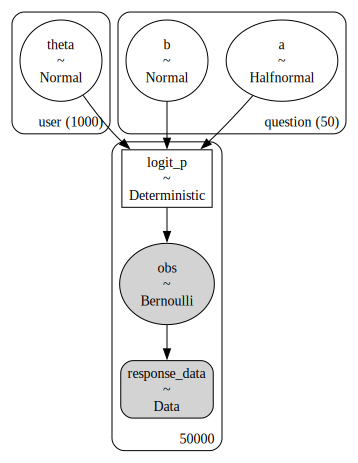

In [8]:
# 配列の項目定義(ユーザー軸と問題軸の2軸)
# coords を指定すると、PyMC 内部で「user 次元」「question 次元」のラベル付き配列として
# パラメータを管理できるようになる（ArviZでの可視化や解釈が圧倒的に楽になる）。
# 理論的には、受験者集合 U、設問集合 Q に対応し、
#   theta ∈ R^U, a ∈ R_+^Q, b ∈ R^Q
# を「どの添字がどれか分かる形」で持てるようにする仕組み。
coords = {"user": users, "question": questions}

# 確率モデルインスタンスの定義
# ここで coords を渡すことで、以降 dims='user' などの指定が使える。
model1 = pm.Model(coords=coords)

with model1:
    # 観測値の配列(1:正答　0:誤答)
    # response は long 形式で一次元化された観測列 y_i（i=1,...,N）。
    # pm.Data を使うことで「固定データとして尤度に渡す」立場を明確化し、
    # 予測や再サンプリング時に set_data で差し替える拡張も可能になる。
    response_data = pm.Data("response_data", response)

    # 能力値（受験者ごと）
    # 2PL（2-parameter logistic）IRT の受験者パラメータ θ_u。
    # 標準的な事前として N(0,1) を置き、能力は平均0・分散1のスケールで
    # 相対比較するというIRTの識別性（ゲージ）を確保している。
    # dims='user' により theta は U 次元ベクトルとして扱われる。
    theta = pm.Normal("theta", mu=0.0, sigma=1.0, dims="user")

    # 識別力（設問ごと）
    # 設問パラメータ a_q（discrimination）。
    # a_q > 0 である必要があるため HalfNormal を採用。
    # a_q が大きいほど、(θ - b) の変化が正答確率に鋭く反映され、
    # 設問が「能力差を見分けやすい（傾きが急）」ことを意味する。
    a = pm.HalfNormal("a", sigma=1.0, dims="question")

    # 困難度（設問ごと）
    # 設問パラメータ b_q（difficulty）。
    # b_q は実数全域を取りうるので Normal を採用。
    # b_q が大きいほど「高い能力がないと正答しにくい設問」と解釈される。
    b = pm.Normal("b", mu=0.0, sigma=1.0, dims="question")

    # logit_p の計算 (2パラメータ・ロジスティックモデル（2PLM）)
    # 観測 i は (user_idx[i], question_idx[i]) に対応しており、
    # それぞれのパラメータをインデックス参照で引き当てる。
    #
    # 2PL モデルの理論式：
    #   P(y_i = 1 | θ, a, b) = sigmoid( a_{q_i} ( θ_{u_i} - b_{q_i} ) )
    #
    # したがって logit（対数オッズ）は
    #   logit p_i = a_{q_i} ( θ_{u_i} - b_{q_i} )
    #
    # pm.Deterministic にしておくと、
    # 事後サンプルごとの p_i / logit_p_i をそのまま取り出せて
    # 予測分布やフィット診断に使いやすい。
    logit_p = pm.Deterministic(
        "logit_p", a[question_idx] * (theta[user_idx] - b[question_idx])
    )

    # ベルヌーイ分布の定義(1:正答　0:誤答)
    # 観測 y_i は二値なので Bernoulli 尤度を置く。
    # logit_p を直接渡すことで数値的に安定したロジスティック回帰形の尤度になる。
    # これにより、受験者能力 θ と設問特性 (a,b) の事後分布
    #   p(θ, a, b | y)
    # を NUTS などでサンプリングする典型的なIRT推論が実装される。
    obs = pm.Bernoulli("obs", logit_p=logit_p, observed=response_data)

# モデルのグラフィカルな構造を可視化
# 「受験者パラメータ θ」「設問パラメータ a,b」→ logit_p → 観測 obs
# という 2PL-IRT の階層構造が正しく描かれているか確認するための出力。
g = pm.model_to_graphviz(model1)
display(g)

In [9]:
%%time

with model1:
    idata1 = pm.sample(random_seed=42)
     

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 105 seconds.


CPU times: user 12.9 s, sys: 2.12 s, total: 15 s
Wall time: 1min 54s


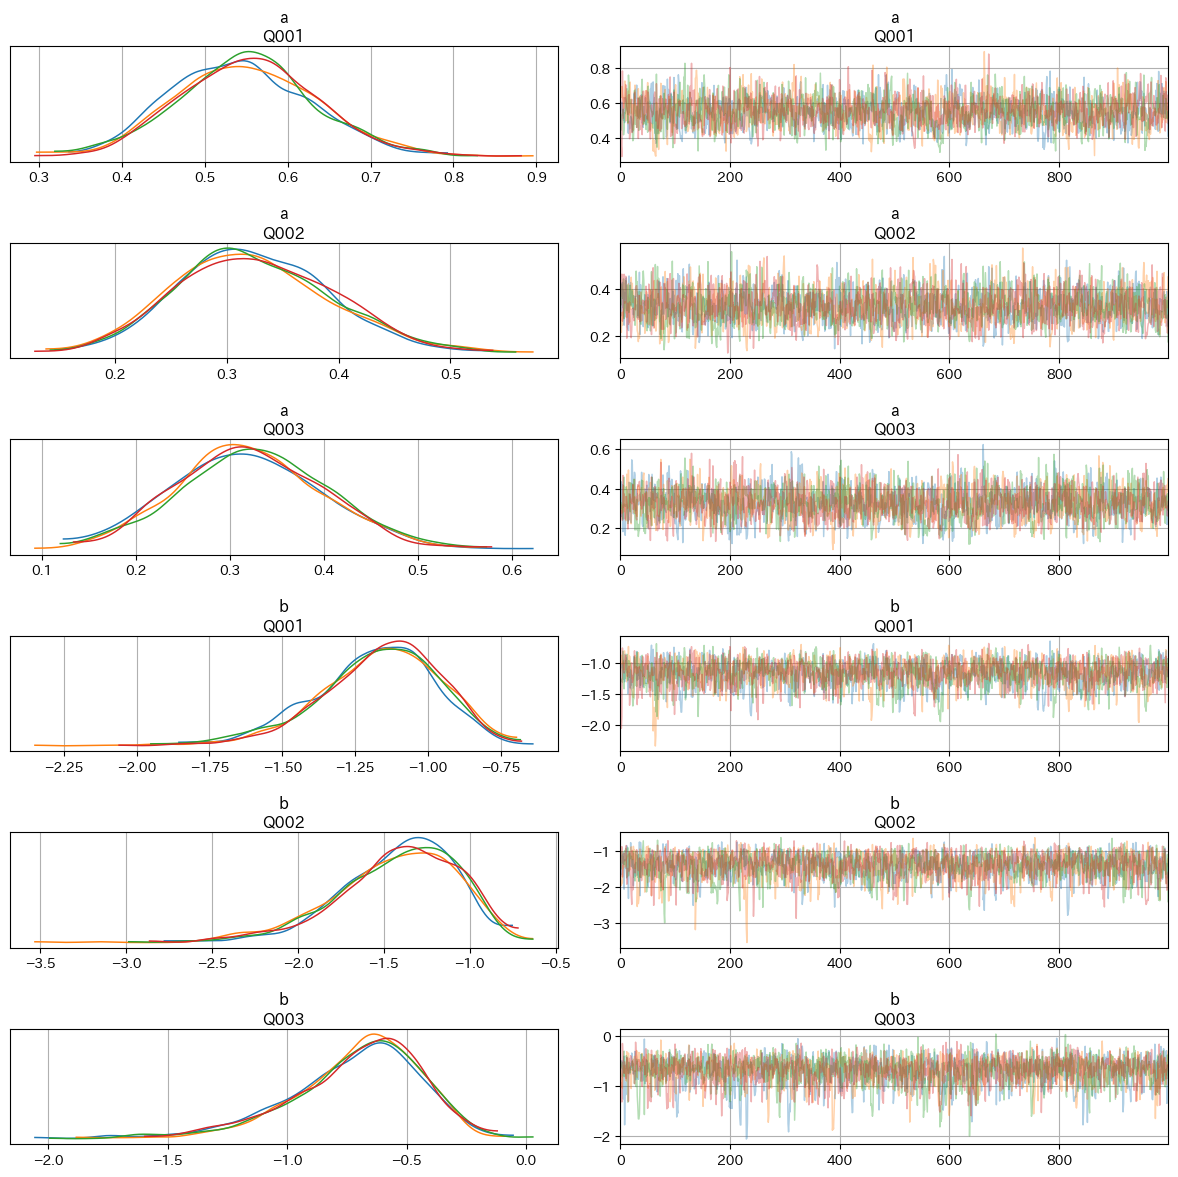

In [10]:
coords_q = {"question": ["Q001", "Q002", "Q003"]}
az.plot_trace(idata1, var_names=["a", "b"], coords=coords_q, compact=False)
plt.tight_layout()

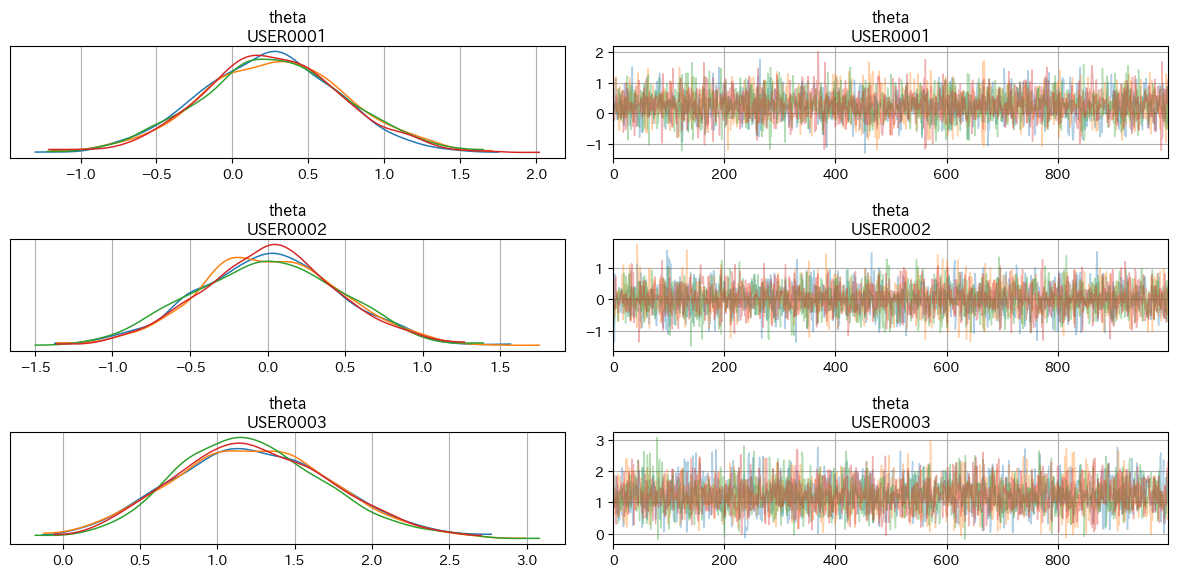

In [11]:
coords_u = {"user": ["USER0001", "USER0002", "USER0003"]}
az.plot_trace(idata1, var_names=["theta"], coords=coords_u, compact=False)
plt.tight_layout()

In [12]:
summary_a1 = az.summary(idata1, var_names=["a"])
summary_b1 = az.summary(idata1, var_names=["b"])
display(summary_a1.head())
display(summary_b1.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[Q001],0.549,0.084,0.395,0.706,0.002,0.001,1568.000,1766.000,1.000
a[Q002],0.324,0.068,0.198,0.452,0.001,0.001,2021.000,2146.000,1.000
a[Q003],0.323,0.078,0.183,0.475,0.002,0.001,1585.000,1946.000,1.000
a[Q004],0.686,0.099,0.497,0.866,0.003,0.002,1286.000,1668.000,1.000
a[Q005],0.754,0.102,0.568,0.952,0.003,0.002,1486.000,1819.000,1.000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[Q001],-1.170,0.209,-1.573,-0.803,0.005,0.005,1618.000,1647.000,1.000
b[Q002],-1.422,0.349,-2.091,-0.846,0.008,0.007,2174.000,1808.000,1.000
b[Q003],-0.710,0.277,-1.258,-0.259,0.007,0.006,1757.000,1849.000,1.000
b[Q004],-1.813,0.258,-2.285,-1.356,0.007,0.005,1365.000,1724.000,1.000
b[Q005],-2.341,0.294,-2.882,-1.815,0.008,0.006,1419.000,1739.000,1.000


In [13]:
summary_theta1 = az.summary(idata1, var_names=["theta"])
display(summary_theta1.head())

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[USER0001],0.262,0.469,-0.591,1.165,0.007,0.008,4173.000,2702.000,1.000
theta[USER0002],0.009,0.461,-0.872,0.871,0.007,0.007,4877.000,2903.000,1.000
theta[USER0003],1.230,0.510,0.274,2.173,0.008,0.008,4581.000,2946.000,1.000
theta[USER0004],-0.760,0.453,-1.599,0.091,0.007,0.007,3925.000,2735.000,1.000
theta[USER0005],-0.560,0.462,-1.445,0.284,0.007,0.008,4299.000,2652.000,1.000


In [14]:
# 受験者ごとの正答率*100を計算し「素点」とする
df_sum1 = pd.DataFrame((df.mean(axis=1) * 100), columns=["素点"])

# 素点を別変数にコピー
X = df_sum1.copy()

# 素点を偏差値のスケールに補正
X_mean, X_std = X.mean(), X.std()
X = (X - X_mean) / X_std * 10 + 50
df_sum1["偏差値"] = X

# 受験者ごとの能力値の平均を抽出
x1 = summary_theta1["mean"]

# 能力値を偏差値と同じスケールに補正
x1_mean, x1_std = x1.mean(), x1.std()
x1 = (x1 - x1_mean) / x1_std * 10 + 50
df_sum1["能力値"] = x1.values

# 結果の確認
display(df_sum1.head(10))

,素点,偏差値,能力値
USER0001,64.000,53.307,52.666
USER0002,58.000,48.449,49.621
USER0003,78.000,64.642,64.317
USER0004,48.000,40.352,40.365
USER0005,50.000,41.971,42.772
USER0006,62.000,51.687,49.151
USER0007,52.000,43.591,41.701
USER0008,54.000,45.210,44.734
USER0009,60.000,50.068,49.055
USER0010,62.000,51.687,49.115


Text(0, 0.5, '能力値')

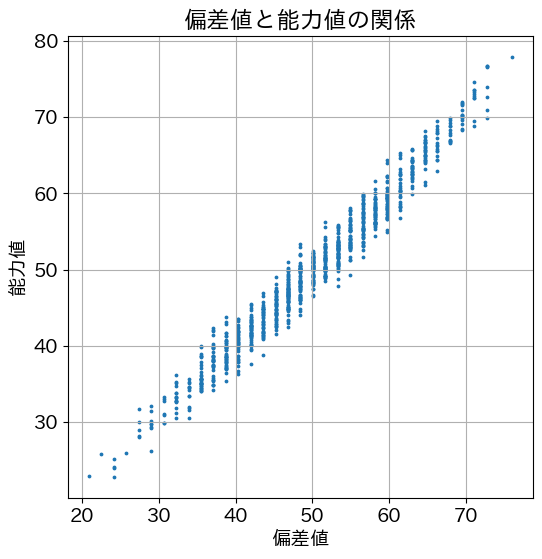

In [15]:
plt.scatter(df_sum1["偏差値"], df_sum1["能力値"], s=3)
plt.title("偏差値と能力値の関係")
plt.xlabel("偏差値")
plt.ylabel("能力値")

In [16]:
# 1. 素点62点(偏差値51.69)の受験者を抽出
df_62_1 = df_sum1.query("素点==62")
print(f"素点62点の受験者数: {len(df_62_1)}\n")

# 2. 一番能力値の低い受験者を抽出
argmin1 = df_62_1["能力値"].values.argmin()
print("素点62点で一番能力値の低い受験者\n", df_62_1.iloc[argmin1], "\n")

# 3. 一番能力値の高い受験者を抽出
argmax1 = df_62_1["能力値"].values.argmax()
print("素点62点で一番能力値の高い受験者\n", df_62_1.iloc[argmax1])

素点62点の受験者数: 59

素点62点で一番能力値の低い受験者
 素点    62.000
偏差値   51.687
能力値   48.501
Name: USER0463, dtype: float64 

素点62点で一番能力値の高い受験者
 素点    62.000
偏差値   51.687
能力値   56.193
Name: USER0064, dtype: float64


In [17]:
# 二人の受験者の問題ごとの正答を抽出
w1 = df.loc[["USER0463", "USER0064"]]
display(w1)
w2 = w1.sum(axis=1)
print(f"w1のshape: {w1.shape}\n正解数:\n{w2}\n")

# 問題別の平均困難度
b_mean1 = az.summary(idata1, var_names=["b"])["mean"].values.reshape(1, -1)
print(b_mean1)
print(f"b_meanのshape: {b_mean1.shape}\n")

# 二人の受験者が解いた問題の平均困難度
w3 = (w1 * b_mean1).sum(axis=1) / w2.iloc[0]
print(w3)

,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
USER0463,0,0,1,1,1,1,1,1,0,0,1,0,1,0,0,0,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,1,1,0,0,1,1
USER0064,1,0,1,1,1,0,1,0,0,0,0,1,1,0,1,1,1,1,1,0,0,1,1,0,1,0,1,1,0,1,0,0,1,1,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,1


w1のshape: (2, 50)
正解数:
USER0463    31
USER0064    31
dtype: int64

[[-1.170 -1.422 -0.710 -1.813 -2.341 -1.406 -2.119 -1.837  1.245  1.283
  -0.573 -1.946 -0.681  0.280 -0.092  0.329  0.073 -2.376 -1.763 -1.037
  -1.548 -1.842  1.357 -1.495  1.283  1.065 -1.687 -0.287 -1.933 -2.214
  -0.179  0.012 -0.911 -0.650 -1.261  0.261 -1.559 -1.402 -2.088  0.598
  -0.071 -1.298 -2.860 -1.378  0.611  0.453  0.525 -1.750 -2.001 -1.890]]
b_meanのshape: (1, 50)

USER0463   -1.207
USER0064   -1.116
dtype: float64


Text(0.5, 1.0, 'サンプル値ごとの能力値の分布')

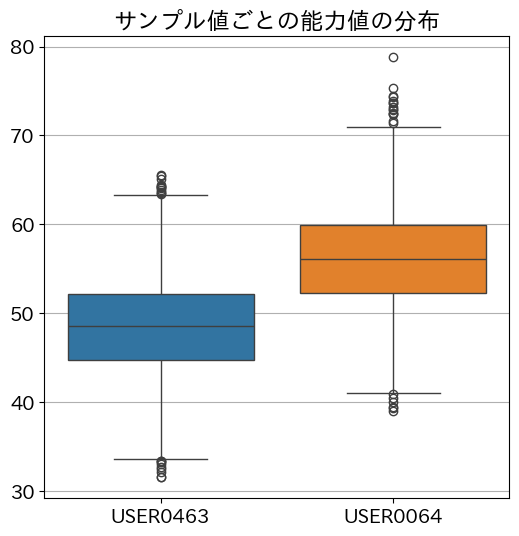

In [18]:
# USER0463とUSER0064の能力値のサンプルデータを抽出
w1 = idata1["posterior"].data_vars["theta"].loc[:, :, ["USER0463", "USER0064"]].values

# 軸の順番を入れ替え後、受験者を第一要素とする行列に変換
w2 = w1.transpose().reshape(2, -1)

# 能力値のスケール変更
w3 = (w2 - x1_mean) / x1_std * 10 + 50

# 受験者を列名とするデータフレームに変換
df_w3 = pd.DataFrame(w3.T, columns=["USER0463", "USER0064"])

# Seabornのboxplot関数で可視化
sns.boxplot(df_w3)
plt.title("サンプル値ごとの能力値の分布")